## Group project 

In [23]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

## Generate the synthetic data set 

In [24]:
bernoulli = random.random()
print(f'Random bernoulli variable is assigned as {bernoulli}')
x = np.random.uniform(0, 10, 1000)
label = np.random.binomial(1, bernoulli, 1000)
noise_a = np.random.normal(0, 1, 1000) 
noise_b = np.random.normal(0, 3, 1000)
d = {'x': x, 'label': label, 'noise_a': noise_a, 'noise_b': noise_b}
df = pd.DataFrame(data=d)
df.loc[df.label == 0, 'y'] = df.x * 3 + 2 + df.noise_a
df.loc[df.label == 1, 'y'] = df.x * 4 + 10 + df.noise_b
df

Random bernoulli variable is assigned as 0.5714025946899135


,x,label,noise_a,noise_b,y
0,4.129757,1,0.517107,-1.263168,25.255862
1,1.036179,0,-1.178729,-1.921947,3.929809
2,0.478335,0,0.789319,-0.699236,4.224323
3,6.715816,1,-0.571943,2.321507,39.184771
4,2.093723,1,-0.704976,2.396016,20.770909
...,...,...,...,...,...
995,6.383842,1,0.851083,-0.171366,35.364002
996,8.262191,1,-0.024822,8.502226,51.550991
997,9.046855,1,-0.921721,-2.029634,44.157786
998,5.891260,0,0.473776,-0.454986,20.147557


## Plotting the data for a first overview 

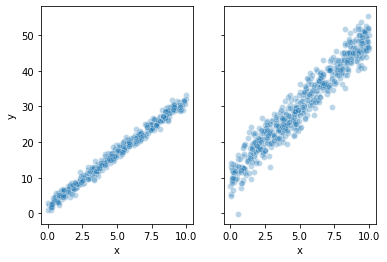

In [25]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=df[df.label == 0],x='x', y='y', alpha=0.3,ax=ax[0])
sns.scatterplot(data=df[df.label == 1],x='x', y='y', alpha=0.3,ax=ax[1])


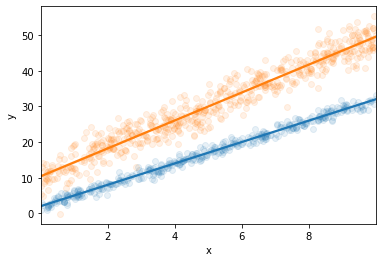

In [26]:
sns.regplot(data=df[df.label == 0],x='x', y='y',scatter_kws={'alpha':0.1})
sns.regplot(data=df[df.label == 1],x='x', y='y',scatter_kws={'alpha':0.1})


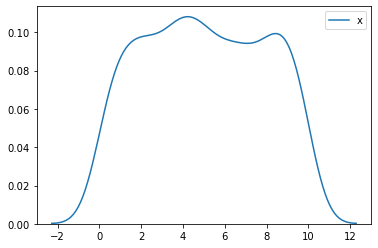

In [27]:
sns.kdeplot(data=df.x)

# Second part: mathematical background 

To Do !

# Third part: Implementation of the EM algorithm 

## Initialization 

In [114]:
# initialization of the parameter
variance_a = random.randint(1, 3) #needs to be >= 0
variance_b = random.randint(1, 3) #needs to be >= 0

beta_a0 = beta_b0 = 0.5
beta_a1 = beta_b1 = 1
prob_a = 0.50
prob_b = 0.50

parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
parameter_list

[0.5, 1, 1, 3, 0.5, 1, 0.5, 0.5]

## Setting the weights 

In [115]:
w_a_numerator  = prob_a * (1/np.sqrt(2*np.pi*variance_a)) * np.exp((-(1/(2*variance_a)) * (df.y - beta_a0 - beta_a1*df.x)**2))
w_b_numerator = prob_b * (1/np.sqrt(2*np.pi*variance_b)) * np.exp((-(1/(2*variance_b)) * (df.y - beta_b0 - beta_b1*df.x)**2))

w_sum = w_a_numerator + w_b_numerator
print(w_a_numerator[0], w_b_numerator[0],w_sum[0])
w_a = w_a_numerator/w_sum
w_b = w_b_numerator/w_sum

8.2715747595679e-94 1.8502148082134346e-32 1.8502148082134346e-32


In [116]:
w_data = pd.DataFrame(data = {'w_a':w_a,'w_b':w_b})
w_data.head()

,w_a,w_b
0,4.470602e-62,1.000000
1,2.041566e-01,0.795843
2,4.913312e-02,0.950867
3,1.935849e-148,1.000000
4,2.551527e-48,1.000000


## Expectation step

In [117]:
#parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
parameter_list

[0.5, 1, 1, 3, 0.5, 1, 0.5, 0.5]

In [118]:
##Expectation step
def Estep(parameter_list):
    
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]
    
    #Set the values for the algorithm
    
    w_a_numerator  = prob_a * (1/np.sqrt(2*np.pi*variance_a)) * np.exp((-(1/(2*variance_a)) * (df.y - beta_a0 - beta_a1*df.x)**2))
    w_b_numerator = prob_b * (1/np.sqrt(2*np.pi*variance_b)) * np.exp((-(1/(2*variance_b)) * (df.y - beta_b0 - beta_b1*df.x)**2))

    w_sum = w_a_numerator + w_b_numerator

    w_a = w_a_numerator/w_sum
    w_b = w_b_numerator/w_sum
    
    return(w_a,w_b)


## Maximisation step

In [119]:
parameter_list

[0.5, 1, 1, 3, 0.5, 1, 0.5, 0.5]

In [120]:
## Maximisation step:
def Mstep(w_a, w_b, parameter_list, df):
    
    #parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]
       
    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    prob_a = w_a.sum()/(w_a +w_b).sum()
    prob_b = w_b.sum()/(w_a +w_b).sum()

    
    #Update the betas for each subgroup
    #Beta_0
    
    beta_a0 = ((df.y - beta_a1*df.x)*w_a).sum()/w_a.sum() 
    beta_b0 = ((df.y - beta_b1*df.x)*w_b).sum()/w_b.sum() 
  
    
    beta_a1 = ((df.y - beta_a0)*w_a).sum()/(w_a*df.x).sum() 
    beta_b1 = ((df.y - beta_b0)*w_b).sum()/(w_b*df.x).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - beta_a0-beta_a1*df.x
    e_hat_b = df.y - beta_b0-beta_b1*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    variance_a = ((e_hat_a**2)*w_a).sum()/w_a.sum()
    variance_b = ((e_hat_b**2)*w_b).sum()/w_b.sum()

    #Store the new parameters in a parameter_list
    parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
    return parameter_list
    

In [121]:
Mstep(w_a,w_b, parameter_list,df)

[2.09241015839386,
 1.0000000000000009,
 1.0254701382197136,
 103.45435889682614,
 19.992665811569857,
 1.0000000000000004,
 0.011766774193260792,
 0.9882332258067392]

## Defining the average likelihood function

In [122]:
def get_avg_log_likelihood(w_a,w_b,df, parameter_list):
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]   
    
    Q_function_a = -1/2*((w_a*((df.y-beta_a0-beta_a1*df.x)**2-math.log(variance_a))).sum())
    Q_function_b = -1/2*((w_b*((df.y-beta_b0-beta_b1*df.x)**2-math.log(variance_b))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

In [130]:
def run_em(df, parameter_list):
    avg_loglikelihoods = []
    while True: 
        #Estimation step
        w_a,w_b = Estep(parameter_list) 
        
        #Maximisation step:
        parameter_list = Mstep(w_a,w_b,parameter_list,df) #Update the maximisation step
        
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(w_a,w_b,df, parameter_list)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return parameter_list, avg_loglikelihoods

In [131]:
test = run_em(df, parameter_list)

In [132]:
test

([14.758802099408978,
  1.000000000000001,
  44.92977325088934,
  30.283435041726776,
  32.748755988101315,
  0.999999999999995,
  0.7207755241081688,
  0.27922447589183114],
 [-48832.131203295554,
  -49021.105110574776,
  -48837.69098691394,
  -48533.204737467546,
  -48171.641018569484,
  -47792.023766744605,
  -47421.44161096598,
  -47072.62392978952,
  -46745.59238278538,
  -46433.94775226167,
  -46130.90561697636,
  -45832.581723477575,
  -45538.99285679441,
  -45253.63887589225,
  -44982.02975832383,
  -44729.700981219976,
  -44500.60280501386,
  -44296.44009585912,
  -44116.88280455915,
  -43960.205828853075,
  -43823.96061140861,
  -43705.48264273988,
  -43602.201626299604,
  -43511.79597086394,
  -43432.2475249139,
  -43361.84129455057,
  -43299.13913770357,
  -43242.94394162934,
  -43192.26276199811,
  -43146.27280595384,
  -43104.2917099083,
  -43065.75236009044,
  -43030.18195630852,
  -42997.184806453755,
  -42966.42829075812,
  -42937.631462728044,
  -42910.55581321741,
  

## Plotting the iterations 

In [126]:
loglikelihoods = test[1]
iterations = np.arange(0,len(loglikelihoods),1)
data_log = pd.DataFrame(data={'logs': loglikelihoods, 'iterations': iterations})

In [127]:
data_log

,logs,iterations
0,-48832.131203,0
1,-49021.105111,1
2,-48837.690987,2
3,-48533.204737,3
4,-48171.641019,4
...,...,...
286,-18637.204962,286
287,-18600.149618,287
288,-18576.224496,288
289,-18566.668001,289


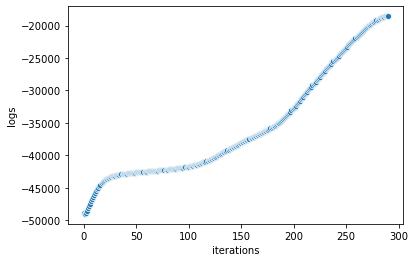

In [128]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)